# Imports

In [53]:
from utils import load_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# autoreload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [54]:
file_path = "../raw_data/joueurs_ligue1_2024_2025.csv"
data = load_data(file_path)
data.head()

Data loaded successfully from ../raw_data/joueurs_ligue1_2024_2025.csv


,equipe,player_id,player_name,player_country_code,age,positions,matches_played,starts,min,gls,...,fls_com,fls_drawn,offside,pk_won,pk_conceded,og,ball_recov,air_dual_won,air_dual_lost,pct_air_dual_won
0,Angers,c3e4ecbb,Jordan Lefort,FRA,30.0,DF,34,34,3060.0,0.0,...,14.0,15.0,1.0,0.0,1.0,0.0,110.0,40.0,28.0,58.8
1,Angers,9d420dad,Yahia Fofana,CIV,23.0,GK,33,33,2970.0,0.0,...,0.0,11.0,0.0,0.0,0.0,0.0,36.0,6.0,3.0,66.7
2,Angers,7978cbf0,Himad Abdelli,ALG,24.0,"MF,FW",32,32,2842.0,6.0,...,48.0,32.0,3.0,0.0,0.0,0.0,193.0,13.0,20.0,39.4
3,Angers,6bfb4303,Florent Hanin,ALG,34.0,DF,33,31,2672.0,1.0,...,16.0,35.0,1.0,0.0,0.0,0.0,132.0,15.0,28.0,34.9
4,Angers,48b28bfd,Jean-Eudes Aholou,CIV,30.0,MF,26,26,1959.0,2.0,...,50.0,25.0,1.0,0.0,0.0,0.0,100.0,38.0,23.0,62.3


## Initial Filtering

In [55]:
# KEEP PLAYERS WHO HAVE PLAYED MORE THAN X MINUTES

min_player_threshold = 500
col_minutes = 'min'
data[col_minutes] = pd.to_numeric(data[col_minutes], errors='coerce')
data_cleaned = data.dropna(subset=[col_minutes])

data_clean = data_cleaned[data_cleaned[col_minutes] > min_player_threshold]

print(f"Number of players with more than {min_player_threshold} minutes played: {data_clean.shape[0]}")

# DUPLICATE player_id DETECTION

if data_clean.duplicated(subset=["player_id"]).any():
    n_dupes = data_clean.duplicated(subset=["player_id"]).sum()
    print(f"{n_dupes} duplicates found on 'player_id'.")
    data_clean = (
        data_clean.sort_values(by="min", ascending=False)
            .drop_duplicates(subset=["player_id"], keep="first")
    )
else:
    print("No duplicates found on 'player_id' ✅")

print(f"Number of players with more than {min_player_threshold} minutes played & without duplicates: {data_clean.shape[0]}")

# REMOVE GARDIENS DE BUT
data_clean = data_clean[~data_clean['positions'].str.contains("GK")]
print(f"Number of outfield players (GK removed): {data_clean.shape[0]}")

Number of players with more than 500 minutes played: 361
5 duplicates found on 'player_id'.
Number of players with more than 500 minutes played & without duplicates: 356
Number of outfield players (GK removed): 333


## Checking for Empty Columns and Rows

In [56]:
def search_col_almost_empty(dataframe, threshold=0.4):
    """
    Identify columns in the DataFrame that are almost empty based on a given threshold.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to analyze.
    threshold (float): The proportion of missing values to consider a column as almost empty.

    Returns:
    list: A list of column names that are almost empty.
    """
    almost_empty_cols = []
    total_rows = dataframe.shape[0]
    
    for col in dataframe.columns:
        missing_count = dataframe[col].isna().sum()
        if missing_count / total_rows >= threshold:
            almost_empty_cols.append(col)
    
    return almost_empty_cols

almost_empty_columns = search_col_almost_empty(data_clean)
print("Columns that are almost empty:", almost_empty_columns)

Columns that are almost empty: []


In [39]:
def search_almost_empty_rows(dataframe, threshold=0.95):
    """
    Identify rows in the DataFrame that are almost empty based on a given threshold. Print the number of such rows.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to analyze.
    threshold (float): The proportion of missing values to consider a row as almost empty.

    Returns:
    pd.DataFrame: A DataFrame containing the almost empty rows.
    """
    almost_empty_rows = []
    total_cols = dataframe.shape[1]
    
    for index, row in dataframe.iterrows():
        missing_count = row.isna().sum()
        if missing_count / total_cols >= threshold:
            almost_empty_rows.append(index)
    print(f"Number of almost empty rows: {almost_empty_rows}")
    return dataframe.loc[almost_empty_rows]
    
almost_empty_rows = search_almost_empty_rows(data_clean)

Number of almost empty rows: []


## We drop redundant / useless columns

In [57]:
colonnes_per90 = ['per90_gls', 'per90_ast', 'per90_non_pen_gls', 'per90_xg', 'per90_xag',
 'per90_non_pen_xg', 'per90_sh', 'per90_sot', 'per90_sca', 'per90_gca',
 'per90_plus_minus', 'per90_x_plus_minus', 'per90_on_off', 'per90_x_on_off']

manual_cols_to_drop = ['min_per_match_played', 'gls_and_ast', 'tkl_plus_int', 'per90_x_plus_minus', 'per90_plus_minus', 
                      'team_gls_on_pitch', 'team_gls_ag_on_pitch', 'team_xg_on_pitch', 'team_xg_ag_on_pitch', 
                      'subs', 'avg_min_sub', 'unused_sub', 'starts', 'avg_min_starter',
                      'pct_air_dual_won', 'pct_take_on_suc', 'pct_take_on_tkld','touch_live', 'pct_tkl_drb_suc', 
                      'per90_gca', 'per90_sca', 'ast_xag_diff', 'pct_pass_cmp_l', 'pct_pass_cmp_m', 'pct_pass_cmp_s', 'pct_pass_cmp',
                      'gls_xg_diff', 'non_pen_gls_xg_diff', 'gls_per_sh', 'gls_per_sot', 'pct_sot', 'pct_squad_min', 'non_pen_gls',
                      'non_pen_xg', 
                      ]

# We drop redundancies : 
cols_to_drop = list(set(colonnes_per90 + manual_cols_to_drop))
data_clean = data_clean.drop(columns=cols_to_drop, errors='ignore')  # errors='ignore' pour éviter les erreurs si une colonne n'existe pas

# Display of remaining cols :
for col in data_clean.columns:
    print(col)

print(data_clean.shape[1])

equipe
player_id
player_name
player_country_code
age
positions
matches_played
min
gls
ast
xg
xag
pk_made
pk_att
yellow_cards
red_cards
carries_prog
passes_prog
sh
sot
avg_sh_dist
fk_sh
npxg_per_sh
pass_cmp
pass_att
pass_ttl_dist
pass_cmp_s
pass_att_s
pass_cmp_m
pass_att_m
pass_cmp_l
pass_att_l
xa
pass_prog
pass_prog_ttl_dist
key_passes
pass_fthird
pass_opp_box
cross_opp_box
pass_live
pass_dead
pass_fk
through_balls
switches
crosses
pass_offside
pass_blocked
throw_ins
ck
ck_in_swinger
ck_out_swinger
ck_straight
ttl_sca
pass_live_sca
pass_dead_sca
take_on_sca
sh_sca
fld_sca
def_sca
gca
pass_live_gca
pass_dead_gca
take_on_gca
sh_gca
fld_gca
def_gca
tkl
tkl_won
tkl_def_third
tkl_mid_third
tkl_att_third
tkl_drb
tkl_drb_att
blocks
sh_blocked
int
clearances
def_error
touches
touch_def_box
touch_def_third
touch_mid_third
touch_fthird
touch_opp_box
take_on_att
take_on_suc
take_on_tkld
carries
ttl_carries_dist
ttl_carries_prog_dist
carries_fthird
carries_opp_box
carries_miscontrolled
carries_dis

## Handling Missing Values (NaN)

In [59]:
# COUNT OF COLUMNS WITH NaN

nan_by_col = data_clean.isna().sum().sort_values(ascending=False)
nan_by_col = nan_by_col[nan_by_col > 0]

print("📊 Columns containing NaN values:")
display(nan_by_col.to_frame("nb_NaN"))

print(f"\n➡️ Total number of columns with at least one NaN: {len(nan_by_col)}")

# COUNT OF PLAYERS WITH NaN
nan_by_player = data_clean.isna().sum(axis=1)

# Create a view for players who have at least 1 NaN
players_with_nan = data_clean.loc[nan_by_player > 0, ["player_id", "player_name"]].copy()
players_with_nan["missing_count"] = nan_by_player[nan_by_player > 0]

print(f"\n👤 Number of players with at least one NaN: {players_with_nan.shape[0]}")
display(players_with_nan.sort_values("missing_count", ascending=False).head(10))

# CONCLUSIONS: Goalkeepers are often affected. In all identified cases, it means no stat => To be replaced by 0 
data_clean = data_clean.fillna(0)

📊 Columns containing NaN values:


,nb_NaN



➡️ Total number of columns with at least one NaN: 0

👤 Number of players with at least one NaN: 0


,player_id,player_name,missing_count


## Creation of 3 datasets :

### Functions : (*dépraciated*)

In [80]:

def drop_per_90_cols(data, exception_cols=None):
    """
    Drop columns that contain 'per90' in their names from the DataFrame.

    Parameters:
    data (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with 'per90' columns dropped.
    """
    if exception_cols is None:
        exception_cols = []
        
    cols_to_drop = [col for col in data.columns if 'per90' in col and col not in exception_cols]
    data_dropped = data.drop(columns=cols_to_drop)
    
    print(f"Dropped {len(cols_to_drop)} columns containing 'per90'.")
    return data_dropped

def manual_col_drop(data, cols_to_drop):
    """
    Manually drop specified columns from the DataFrame.

    Parameters:
    data (pd.DataFrame): The input DataFrame.
    cols_to_drop (list): List of column names to drop.

    Returns:
    pd.DataFrame: The DataFrame with specified columns dropped.
    """
    data_dropped = data.drop(columns=cols_to_drop, errors='ignore')
    print(f"Dropped {len(cols_to_drop)} specified columns.")
    return data_dropped

def get_string_columns(dataframe):
    """
    Get a list of column names in the DataFrame that have string (object) data type.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    list: A list of column names with string data type.
    """
    string_cols = dataframe.select_dtypes(include=['object']).columns.tolist()
    return string_cols

def convert_string_to_numeric(dataframe, string_cols):
    pass

### Dataset1 : raw data, without normalization

In [64]:
data_clean_raw = data_clean.copy()

#print(data_clean_raw.head(5))

data_clean_raw.to_csv("../cleaned_data/joueurs_ligue1_2024_2025_clean_raw.csv", index=False, encoding="utf-8")
print("✅ CSV export \"joueurs_ligue1_2024_2025_clean_raw\" completed.")

✅ CSV export "joueurs_ligue1_2024_2025_clean_raw" completed.


### Dataset 2 : normalized data / 90 mins played

In [67]:
cols_not_to_normalize = ['equipe', 'player_id', 'player_name', 'player_country_code', 'age', 'positions', 'avg_sh_dist', 'min', 
                              'gls_per_sh', 'gls_per_sot', 'avg_sh_dist', 'npxg_per_sh', 'matches_played']


cols_to_normalize = [c for c in data_clean.columns if c not in cols_not_to_normalize]

# Normalization : we divide by time played and multiply by 90 to get "X / 90 min "
data_clean_normalized = data_clean.copy()
data_clean_normalized[cols_to_normalize] = 90 * data_clean[cols_to_normalize].div(data_clean['min'], axis=0)
data_clean_normalized.rename(columns={c: f"{c}_per90" for c in cols_to_normalize}, inplace=True)

#print(data_clean_normalized.head(5))

data_clean_normalized.to_csv("../cleaned_data/joueurs_ligue1_2024_2025_clean_per90.csv", index=False, encoding="utf-8")
print("✅ CSV export \"joueurs_ligue1_2024_2025_clean_per90\" completed.")

✅ CSV export "joueurs_ligue1_2024_2025_clean_per90" completed.


### Dataset 3 : normalized data, custom selected columns

In [ ]:
#TO BE DONE

## Co-variance analysis

### Fonctions

In [77]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np

def redundantColumnsCovariance(data, threshold=0.9, cols_not_to_analyze=None):
    if cols_not_to_analyze is None:
        cols_not_to_analyze = ['equipe', 'player_id', 'player_name', 'player_country_code', 'age', 'positions']
        
    cols_to_analyze = [c for c in data.columns if c not in cols_not_to_analyze]
    data_to_analyze = data[cols_to_analyze]
        
    corr_matrix = data_to_analyze.corr().abs()

    # Colonnes redondantes à supprimer
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(len(cols_to_drop) ," colonnes redondantes à supprimer :", cols_to_drop)
    return cols_to_drop


def lowVarianceColumns(data, threshold=0.01, cols_not_to_analyze=None):
    if cols_not_to_analyze is None:
        cols_not_to_analyze = ['equipe', 'player_id', 'player_name', 'player_country_code', 'age', 'positions']
    
    cols_to_analyze = [c for c in data.columns if c not in cols_not_to_analyze]
    
    selector = VarianceThreshold(threshold=threshold)  # seuil ajustable
    selector.fit(data[cols_to_analyze])
    
    # Colonnes à garder
    cols_keep = data[cols_to_analyze].columns[selector.get_support()]
    
    # Colonnes à supprimer = celles qui n'ont pas passé le seuil
    cols_to_drop = [c for c in cols_to_analyze if c not in cols_keep]

    print(len(cols_to_drop) ," colonnes à supprimer pour faible variance :",cols_to_drop)
    return cols_to_drop



34  colonnes à supprimer pour faible variance : ['gls_per90', 'ast_per90', 'xg_per90', 'xag_per90', 'pk_made_per90', 'pk_att_per90', 'yellow_cards_per90', 'red_cards_per90', 'fk_sh_per90', 'npxg_per_sh', 'xa_per90', 'cross_opp_box_per90', 'through_balls_per90', 'switches_per90', 'pass_offside_per90', 'ck_straight_per90', 'take_on_sca_per90', 'sh_sca_per90', 'fld_sca_per90', 'def_sca_per90', 'gca_per90', 'pass_live_gca_per90', 'pass_dead_gca_per90', 'take_on_gca_per90', 'sh_gca_per90', 'fld_gca_per90', 'def_gca_per90', 'tkl_att_third_per90', 'def_error_per90', 'second_yellow_cards_per90', 'offside_per90', 'pk_won_per90', 'pk_conceded_per90', 'og_per90']
28  colonnes redondantes à supprimer : ['pk_att_per90', 'sot_per90', 'pass_att_per90', 'pass_ttl_dist_per90', 'pass_att_s_per90', 'pass_cmp_m_per90', 'pass_att_m_per90', 'pass_att_l_per90', 'xa_per90', 'pass_prog_per90', 'pass_prog_ttl_dist_per90', 'pass_live_per90', 'ck_in_swinger_per90', 'ck_out_swinger_per90', 'ttl_sca_per90', 'pass_l

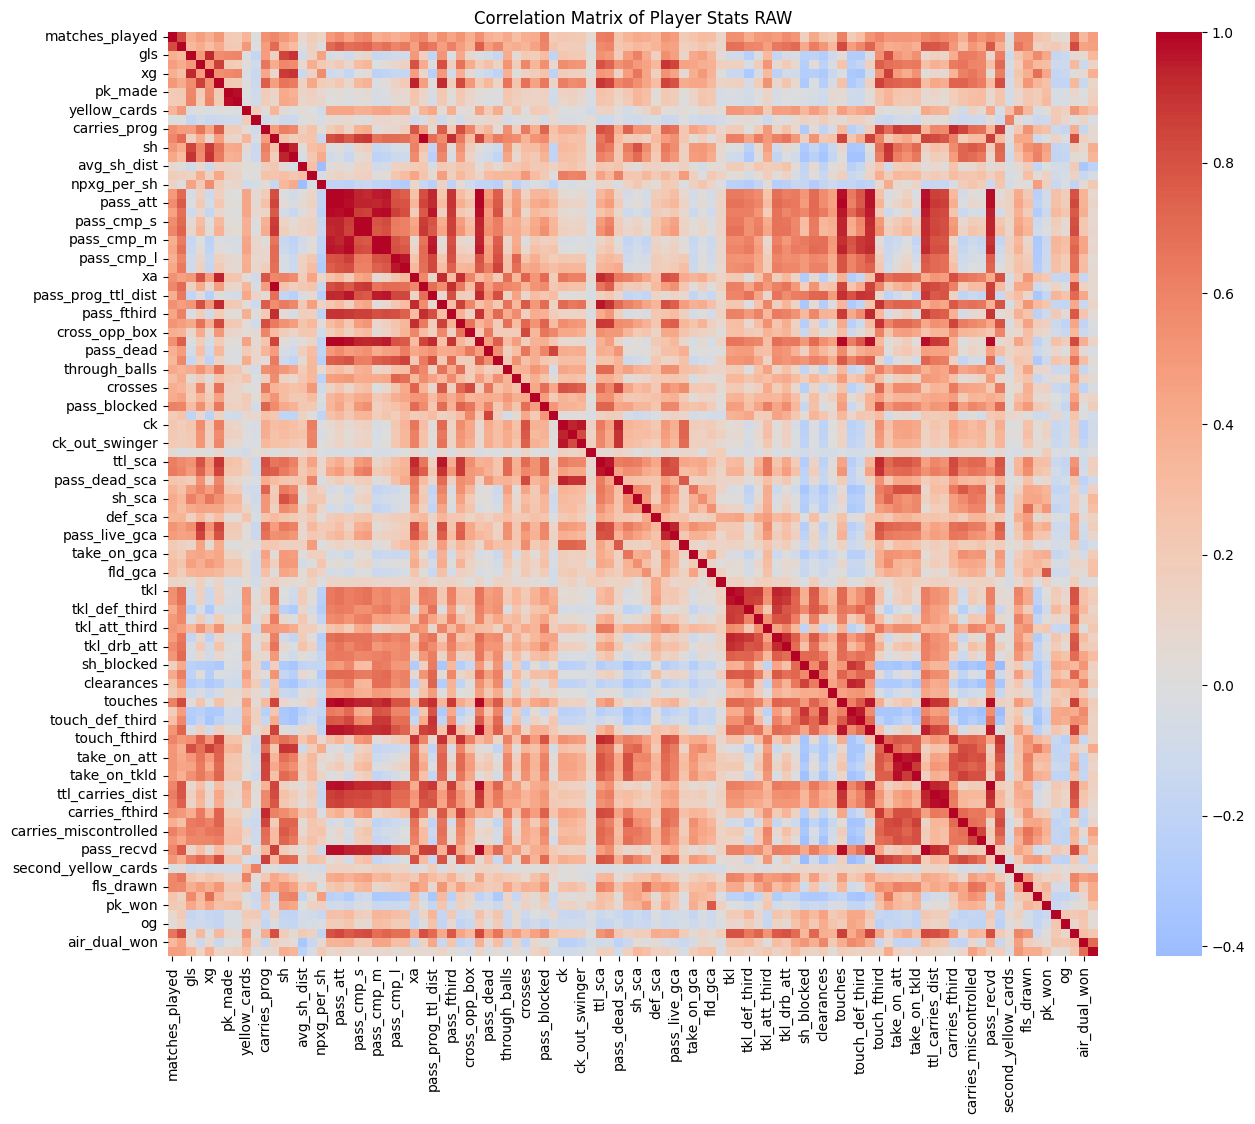

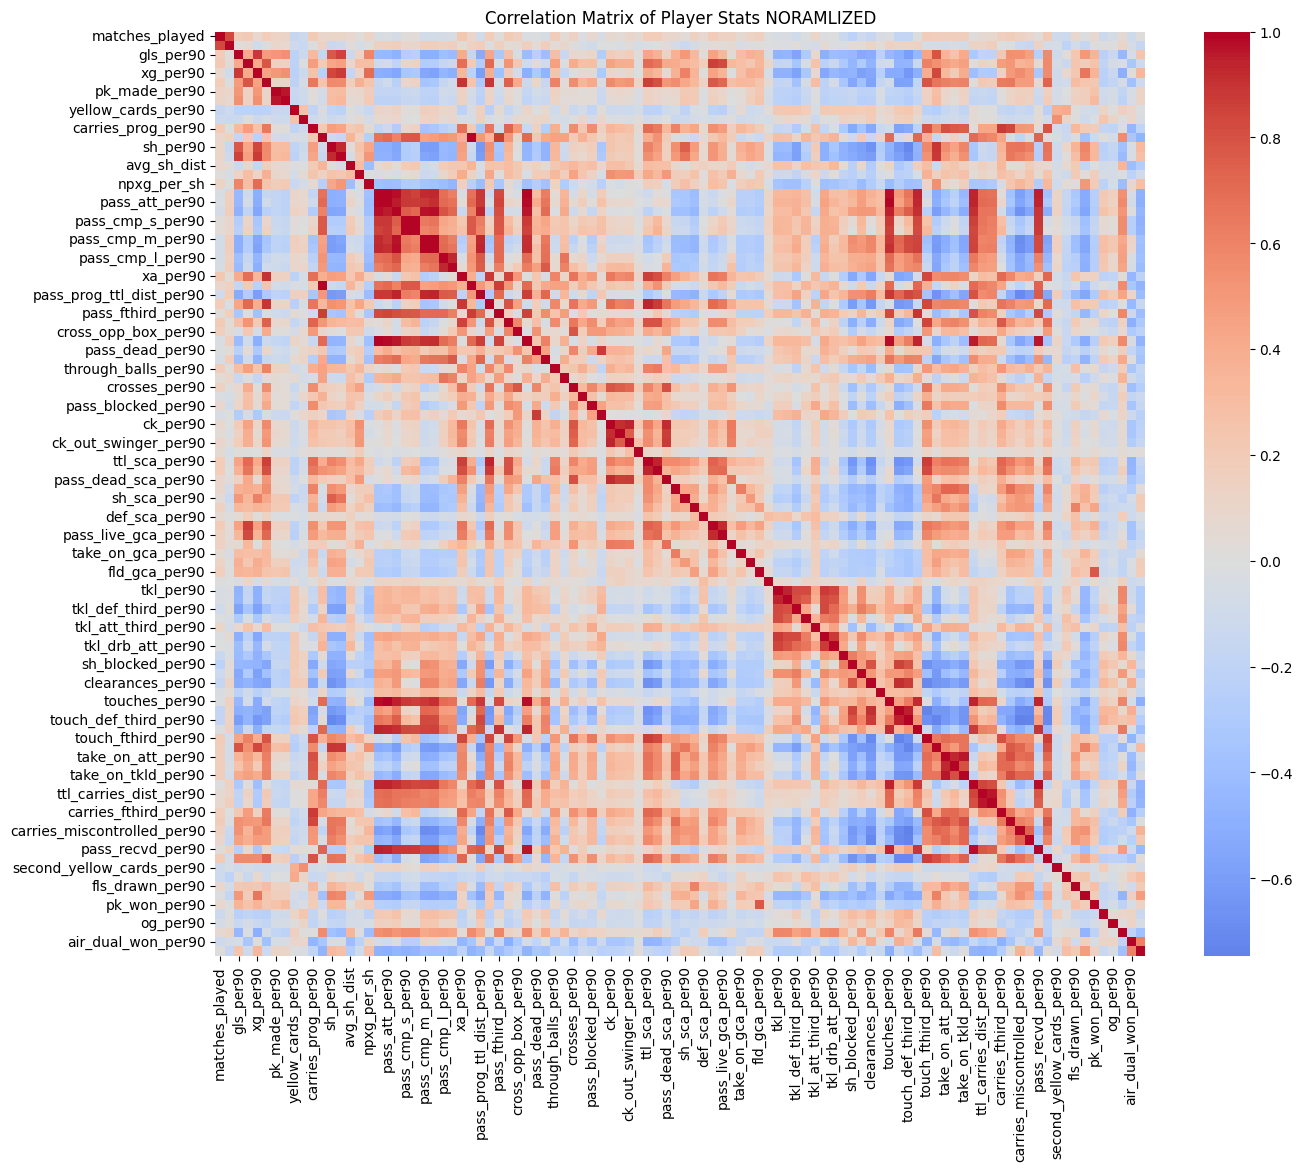

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_not_to_analyze = ['equipe', 'player_id', 'player_name', 'player_country_code', 'age', 'positions']
cols_to_analyze_r = [c for c in data_clean_raw.columns if c not in cols_not_to_analyze]
cols_to_analyze_n = [c for c in data_clean_normalized.columns if c not in cols_not_to_analyze]
cols_to_analyze_raw = data_clean_raw[cols_to_analyze_r]
cols_to_analyze_normalized = data_clean_normalized[cols_to_analyze_n]

a = lowVarianceColumns(cols_to_analyze_normalized, 0.1)
b = redundantColumnsCovariance(cols_to_analyze_normalized, 0.9)
c = lowVarianceColumns(cols_to_analyze_raw, 0.1)
d = redundantColumnsCovariance(cols_to_analyze_raw, 0.9)

corr_matrix_raw = cols_to_analyze_raw.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix_raw, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Player Stats RAW")
plt.show()

corr_matrix_normalized = cols_to_analyze_normalized.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix_normalized, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Player Stats NORAMLIZED")
plt.show()